# Init

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix, vstack
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

import transformers as ppb # pytorch-pretrained-bert
import torch

import pipeline as pp
import models as ml

import importlib

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\madsv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Global variables and create data set

In [3]:
# The number of rows to train the model
BATCH_SIZE = 10000

In [107]:
importlib.reload(pp)
pp.get_dataframe_with_distribution(
    "../datasets/big/dataset.csv", 
    BATCH_SIZE, 
    (0.8, 0.1, 0.1),
    (False, False, False),
    out_file="../datasets/big/10K_balanced.csv",
    get_frame=False
)


running


100%|██████████| 200000/200000 [00:00<00:00, 877732.96it/s]


entries read: 200000


Entire pipeline to vectorize

In [ ]:
# UNDER CONSTRUCTION
importlib.reload(pp)
def vectorize_raw(file, new_file):
    stopwords_lst = stopwords.words('english')
    pp.apply_pipeline(file, [
        (pp.Binary_labels(), 'type'),
        (pp.Clean_data(), 'content'),
        (pp.Tokenizer(), "content"),
        (pp.Remove_stopwords(stopwords_lst), "content"),
        (pp.Stem(), "content")
    ],
    new_file=new_file,
    progress_bar=True)
    


# Statistics raw dataset

Distribution of data

In [41]:
data = pd.read_csv("../datasets/big/10K_balanced.csv")

In [17]:
def get_distribution(data, is_percentage=True):
    for i, label in enumerate(pp.labels):
        if is_percentage:
            percent = len(data[data["type"] == label]) / (data.shape[0])
        else:
            percent = len(data[data["type"] == label])
        print(f"{label}: {percent}", end="")
        print(", ", end="") if i != len(pp.labels) - 1 else _

In [18]:
get_distribution(data, is_percentage=False)

fake: 1020, conspiracy: 1042, junksci: 915, hate: 913, unreliable: 940, bias: 1044, satire: 920, reliable: 1148, clickbait: 934, political: 1124

In [19]:
# find distribution of labels
for i, set_name in enumerate(["train", "val", "test"]):
    set = data[data["set"] == i]
    print(f"Distribution of {set_name} with size {set.shape[0]}:")
    get_distribution(set)
    print("\n") if i != 2 else _

Distribution of train with size 8000:
fake: 0.1, conspiracy: 0.1, junksci: 0.1, hate: 0.1, unreliable: 0.1, bias: 0.1, satire: 0.1, reliable: 0.1, clickbait: 0.1, political: 0.1

Distribution of val with size 1000:
fake: 0.1, conspiracy: 0.1, junksci: 0.1, hate: 0.1, unreliable: 0.1, bias: 0.1, satire: 0.1, reliable: 0.1, clickbait: 0.1, political: 0.1

Distribution of test with size 1000:
fake: 0.12, conspiracy: 0.142, junksci: 0.015, hate: 0.013, unreliable: 0.04, bias: 0.144, satire: 0.02, reliable: 0.248, clickbait: 0.034, political: 0.224

Statistics

In [4]:
# freq plot
importlib.reload(pp)
unique_words = pp.Generate_unique_word_list()
_ = pp.apply_pipeline_pd_tqdm(data, [
    (pp.Tokenizer(), 'content'),
    (unique_words, None, 'content')
])

100%|██████████| 1/1 [00:00<00:00, 500.22it/s]


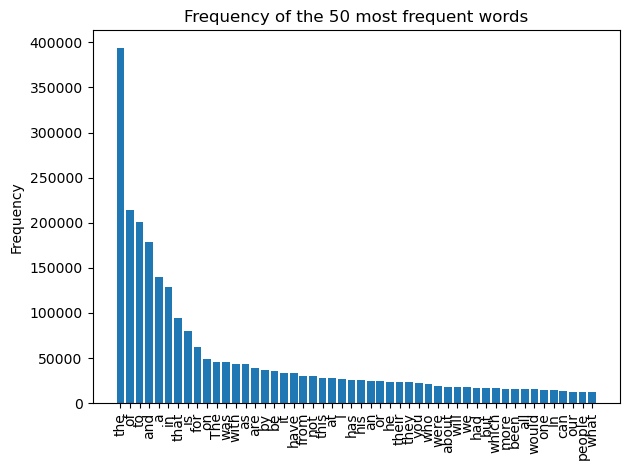

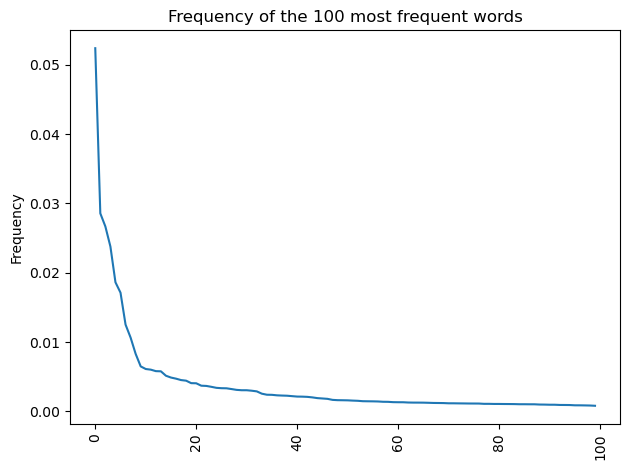

In [8]:
unique_words.plot_most_frequent(50)
unique_words.plot_frequency_line(100)

# Cleaning

Cleaning the data

In [1]:
importlib.reload(pp)

def Clean_data(file):
    stopwords_lst = stopwords.words('english')
    pp.apply_pipeline(file, [
            (pp.Binary_labels(), 'type'),
            (pp.Clean_data(), 'content'),
            (pp.Tokenizer(), "content"),
            (pp.Remove_stopwords(stopwords_lst), "content"),
            (pp.Stem(), "content"),
        ],
        new_file="../datasets/big/10K_cleaned.csv",
        progress_bar=True
    )

cleaned_data = Clean_data("../datasets/big/10K_balanced.csv")

NameError: name 'importlib' is not defined

Creating a list of all words

In [114]:
importlib.reload(pp)

def Get_unique_words(file):
    unique_words = pp.Generate_unique_word_list()
    pp.apply_pipeline(file, [(unique_words, None)], progress_bar=True)
    return unique_words

unique_words = Get_unique_words("../datasets/big/10K_cleaned.csv")

unique_words_list = unique_words.get_unique_words(0,1)
print("words (features):", len(unique_words_list))

100%|██████████| 10000/10000 [00:09<00:00, 1062.81it/s]


finish time: 9.673210859298706
words (features): 77780


# Statistics cleaned data

In [44]:
cleaned_data = pd.read_csv("../datasets/big/10K_cleaned.csv")

In [45]:
def get_distribution(data, is_percentage=True):
    print(f"True: {len(data[data['type'] == True])}, Fake: {len(data[data['type'] == False])}")

# find distribution of labels
cleaned_data = pd.read_csv("../datasets/big/10K_cleaned.csv")
for i, set_name in enumerate(["train", "val", "test"]):
    set = cleaned_data[cleaned_data["set"] == i]
    print(f"Distribution of {set_name} with size {set.shape[0]}:")
    get_distribution(set)

Distribution of train with size 8000:
True: 2400, Fake: 5600
Distribution of val with size 1000:
True: 300, Fake: 700
Distribution of test with size 1000:
True: 506, Fake: 494


[('<num>', 58292), ('<date>', 27886), ('<url>', 20381), ('said', 12481), ('one', 10921), ('?', 10799), ('peopl', 9921), ('like', 9342), ('use', 9080), ('would', 9076), ('year', 8871), ('state', 8752), ('new', 8675), ('time', 8435), ('also', 7631), ('us', 6508), ('make', 6418), ('say', 5915), ('go', 5907), ('get', 5772), ('even', 5672), ('!', 5660), ('system', 5296), ('mani', 5236), ('report', 5214), ('american', 5072), ('may', 5015), ('work', 5013), ('come', 4979), ('govern', 4766), ('nation', 4748), ('could', 4724), ('day', 4683), ('first', 4657), ('call', 4619), ('world', 4557), ('right', 4534), ('news', 4520), ('presid', 4464), ('see', 4458), ('trump', 4453), ('take', 4442), ('two', 4439), ('mr', 4237), ('want', 4194), ('way', 4107), ('continu', 3962), ('countri', 3952), ('know', 3945), ('includ', 3886), ('read', 3879), ('think', 3856), ('public', 3848), ('need', 3802), ('well', 3778), ('last', 3744), ('health', 3739), ('dont', 3594), ('back', 3587), ('polit', 3582), ('help', 3477),

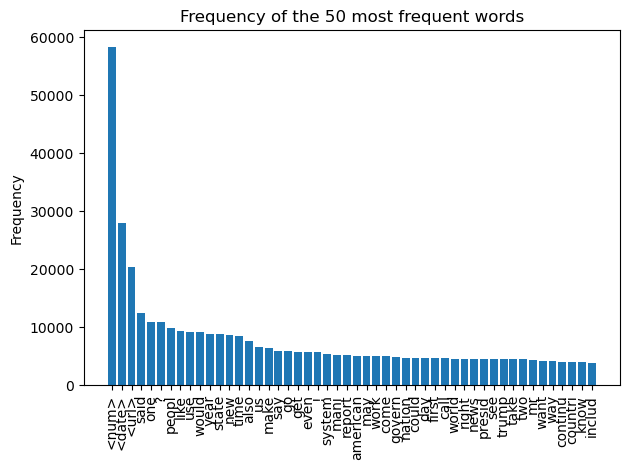

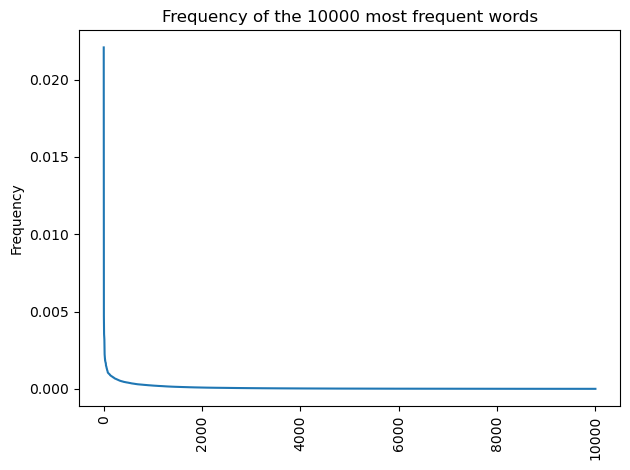

In [46]:
print(unique_words.get_most_frequent(100))
unique_words.plot_most_frequent(50)
unique_words.plot_frequency_line(10000)

# Vectorization of content

Bag of words representation BoW

In [115]:
importlib.reload(pp)

def Vectorize_content(file, new_file, unique_words):
    pp.apply_pipeline(file, [
            (pp.Create_word_vector(unique_words), "content"),
            (pp.Save_numpy_arr(), "content")
        ], 
        new_file=new_file,
        progress_bar=True)

Vectorize_content("../datasets/big/10K_cleaned.csv", "../datasets/big/10K_vectorized.csv", unique_words_list)

100%|██████████| 10000/10000 [06:59<00:00, 23.84it/s]
c:\Users\madsv\miniconda3\envs\penguin\lib\site-packages\pandas\core\ops\array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)
100%|██████████| 10000/10000 [02:01<00:00, 82.24it/s]


finish time: 569.1689488887787


# Other vector formats

In [116]:
vectors = pp.apply_pipeline_pd_tqdm(pd.read_csv("../datasets/big/10K_vectorized.csv", usecols=["content", "type", "set"]), [(pp.Read_numpy_arr(int), "content")])

100%|██████████| 10000/10000 [01:15<00:00, 132.28it/s]
c:\Users\madsv\miniconda3\envs\penguin\lib\site-packages\pandas\core\ops\array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


In [117]:
vectors_normalized = pp.apply_pipeline_pd_tqdm(vectors, [(pp.Normalize(), "content")])

100%|██████████| 10000/10000 [00:06<00:00, 1601.22it/s]


In [118]:
importlib.reload(pp)
vectors_idf = pp.apply_pipeline_pd_tqdm(vectors_normalized, [(pp.TF_IDF(unique_words.n, unique_words.n_t, unique_words_list), None, "content")])

100%|██████████| 10000/10000 [02:22<00:00, 70.31it/s]


In [119]:
def test_split_from_sets(data, col="content"):
    train = data[data["set"] == 0]
    val = data[data["set"] == 1]
    test = data[data["set"] == 2]
    X_train, y_train = csr_matrix(np.stack(train[col])), train["type"].astype(int)
    X_val, y_val = csr_matrix(np.stack(val[col])), val["type"].astype(int)
    X_test, y_test = csr_matrix(np.stack(test[col])), test["type"].astype(int)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [120]:
X_train_vector, X_val_vector, X_test_vector, y_train_vector, y_val_vector, y_test_vector = test_split_from_sets(vectors)

In [121]:
X_train_vector_normalized, X_val_vector_normalized, X_test_vector_normalized, y_train_vector_normalized, y_val_vector_normalized, y_test_vector_normalized = test_split_from_sets(vectors_normalized)

In [122]:
X_train_idf, X_val_idf, X_test_idf, y_train_idf, y_val_idf, y_test_idf = test_split_from_sets(vectors_idf)

# TfidfVectorizer

TfidfVectorizer performs the following operations:
* <strong>Tokenization:</strong> It breaks the text into individual words or tokens.
* <strong>Counting:</strong> It counts the number of occurrences of each token in each document.
* <strong>Normalization:</strong> It calculates the frequency of each token in each document by dividing the count by the total number of tokens in the document.
* <strong>Weighting:</strong> It applies the Tfidf weighting scheme to each token in each document. The Tfidf weight of a token in a document is proportional to its frequency in the document, but inversely proportional to its frequency in the corpus (i.e., the collection of all documents).

In [57]:
importlib.reload(pp)
cleaned_data_combined = pp.apply_pipeline_pd_tqdm(
    pd.read_csv("../datasets/big/10K_cleaned.csv"), [
        (pp.Read_String_Lst(), "content"),
        (pp.Combine_Content(), "content")
    ])

100%|██████████| 10000/10000 [00:00<00:00, 120542.95it/s]


In [65]:
  
def vectorize_content(data, col="content", new_col="count_vectorized"):
    # Prepare the tf-idf (term frequency-inverse document frequency) TODO: read up on this for report
    start_time = time() 
    count_vectorizer = CountVectorizer(ngram_range=(1, 2))
    tf_idf_transformer = TfidfTransformer(smooth_idf=False)

    # fit and transform train data to count vectorizer
    count_vectorizer.fit(data[col].values)
    count_vect_train = count_vectorizer.transform(data[col].values)
    # fit the counts vector to tfidf transformer
    tf_idf_transformer.fit(count_vect_train)
    count_vect_train = tf_idf_transformer.transform(count_vect_train)
    data[new_col] = [x for x in count_vect_train]
    #cleaned_data_combined['count_vectorized'] = cleaned_data_combined['count_vectorized'].apply(lambda x: tf_idf_transformer.transform([x]))

    end_time = time()
    print("Time elapsed for TF IDF transform: ,", end_time - start_time)

In [69]:
def split_csr_data(data, col="content", get_val=True):
    train = data[data["set"] == 0]
    val = data[data["set"] == 1]
    test = data[data["set"] == 2]
    X_train, y_train = vstack(train[col]), train["type"].astype(int)
    X_val, y_val = vstack(val[col]), val["type"].astype(int)
    X_test, y_test = vstack(test[col]), test["type"].astype(int)
    if not get_val:
        return X_train, X_test, y_train, y_test
    return X_train, X_val, X_test, y_train, y_val, y_test

In [58]:
vectorize_content(cleaned_data_combined, col="content", new_col="count_vectorized")
X_train_count, X_val_count, X_test_count, y_train_count, y_val_count, y_test_count = split_csr_data(cleaned_data_combined, col="count_vectorized")

Time elapsed for TF IDF transform: , 18.473822832107544


In [60]:
cleaned_data_combined.head(1)

,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source,set,count_vectorized
0,6301449,nytimes.com,True,https://query.nytimes.com/gst/fullpage.html?re...,editor drop colleg editori march <num> written...,2018-02-11 00:40:10.316783,2018-02-11 00:14:20.346838,2018-02-11 00:14:20.346871,Time to Scrap the Electoral College?,NaN,NaN,"['Presidential Elections (US)', 'Electoral Col...",<br>To the Editor:\n<p>\n Re ''Drop Out of th...,NaN,NaN,nytimes,0,"(0, 1530792)\t0.0904017314777479\n (0, 1530..."


In [126]:
def Vectorize(file, to_csv_file_name=None):

    cleaned_data = pp.apply_pipeline(file, [
            (pp.Binary_labels(), 'type'),
            (pp.Clean_data(), 'content')
        ], 
        get_batch=True, 
        batch_size=BATCH_SIZE)

    print("Shape of data: ", cleaned_data.shape)

    #TODO: how to avoid leaking information from the test set? 
    vect = TfidfVectorizer(stop_words='english', max_df=0.7)
    vect.fit(cleaned_data['content'])
    
    print("Vocabulary: ", len(vect.vocabulary_), " words")
    content_tfidf = vect.transform(cleaned_data['content'])
    print("Shape of vect: ", content_tfidf.shape)

    vectorized_data = {
        "X": content_tfidf,
        "y": cleaned_data['type']
    }

    if to_csv_file_name != None:
        content_tfidf_df = pd.DataFrame(content_tfidf.todense(),columns = vect.get_feature_names_out())
        content_tfidf_df.to_csv(to_csv_file_name, index=False)

    print("Done vectorizing data!")
    return vectorized_data

vectorized_data = Vectorize("../datasets/big/10K_balanced.csv")

Length 10000
Shape of data:  (10000, 17)
Vocabulary:  106578  words
Shape of vect:  (10000, 106578)
Done vectorizing data!


In [127]:
X_train, X_test, y_train, y_test = train_test_split(vectorized_data["X"], vectorized_data["y"].astype(int), test_size=0.20, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

Comparing test data

In [ ]:
print("Dim of tfidf vectorized data: ", X_train.shape, type(X_train))
print("Dim of own vectorized data: ", X_train_vector.shape, type(X_train_vector))

Dim of tfidf vectorized data:  (8000, 110898) <class 'scipy.sparse._csr.csr_matrix'>
Dim of own vectorized data:  (8000, 89450) <class 'scipy.sparse._csr.csr_matrix'>


# Baseline models

In [111]:
backup = pd.DataFrame()
def try_models(models, X_train, X_test, y_train, y_test, name=None):
    global backup
    metrics = []
    for model in models:
        start_time = time() 
        model.fit(X_train, y_train)
        train_time = time() - start_time
        y_train_pred = model.predict(X_train)
        y_pred = model.predict(X_test)
        
        if name == None:
            name = type(model).__name__
        metrics.append({
            "name": name,
            "train_acc": accuracy_score(y_train, y_train_pred),
            "test_acc": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred), 
            "time": "{:.2f}".format(train_time)
        })
        backup = pd.DataFrame(metrics)
        print(f"{name} finished in {(time() - start_time):.2f} seconds")
    return pd.DataFrame(metrics)

In [41]:
metrics = try_models([
        LogisticRegression(),
        MultinomialNB(),
        RandomForestClassifier(max_depth=25),
        DecisionTreeClassifier(),
        AdaBoostClassifier(n_estimators=2),
        SVC(kernel='linear'),
        KNeighborsClassifier(n_neighbors=15, weights='distance'),
        PassiveAggressiveClassifier(),
        
    ], 
    X_train_count, X_test_count, y_train_count, y_test_count
)
"""
LogisticRegression finished in 14.61 seconds
MultinomialNB finished in 0.25 seconds
RandomForestClassifier finished in 49.12 seconds
DecisionTreeClassifier finished in 104.58 seconds
AdaBoostClassifier finished in 34.64 seconds
SVC finished in 187.00 seconds
KNeighborsClassifier finished in 812.41 seconds
PassiveAggressiveClassifier finished in 0.36 seconds

Other models (takes too long)
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1)),
RandomForestClassifier(),
GradientBoostingClassifier(),
GradientBoostingClassifier(max_depth=1),
"""

LogisticRegression finished in 14.61 seconds
MultinomialNB finished in 0.25 seconds
RandomForestClassifier finished in 49.12 seconds
DecisionTreeClassifier finished in 104.58 seconds
AdaBoostClassifier finished in 34.64 seconds
SVC finished in 187.00 seconds
KNeighborsClassifier finished in 812.41 seconds
PassiveAggressiveClassifier finished in 0.36 seconds


In [52]:
# sort metrics by test accuracy
m = metrics.sort_values(by="f1", ascending=False)
# convert dataframe to latex table
print(m.to_latex(index=False))
m

\begin{tabular}{lrrrrrl}
\toprule
                       name &  train\_acc &  test\_acc &  precision &   recall &       f1 &   time \\
\midrule
                        SVC &   0.997125 &     0.840 &   0.845238 & 0.838583 & 0.841897 &  98.09 \\
         LogisticRegression &   0.968250 &     0.835 &   0.842315 & 0.830709 & 0.836472 &  14.57 \\
PassiveAggressiveClassifier &   0.999875 &     0.831 &   0.835644 & 0.830709 & 0.833169 &   0.33 \\
              MultinomialNB &   0.900375 &     0.723 &   0.650587 & 0.982283 & 0.782745 &   0.13 \\
     DecisionTreeClassifier &   1.000000 &     0.770 &   0.781377 & 0.759843 & 0.770459 & 104.50 \\
     RandomForestClassifier &   0.900500 &     0.766 &   0.795259 & 0.726378 & 0.759259 &  43.53 \\
         AdaBoostClassifier &   0.651125 &     0.639 &   0.974194 & 0.297244 & 0.455505 &  34.50 \\
       KNeighborsClassifier &   1.000000 &     0.546 &   1.000000 & 0.106299 & 0.192171 &   0.01 \\
\bottomrule
\end{tabular}



C:\Users\madsv\AppData\Local\Temp\ipykernel_37572\3701784171.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(m.to_latex(index=False))


,name,train_acc,test_acc,precision,recall,f1,time
5,SVC,0.997125,0.840,0.845238,0.838583,0.841897,98.09
0,LogisticRegression,0.968250,0.835,0.842315,0.830709,0.836472,14.57
7,PassiveAggressiveClassifier,0.999875,0.831,0.835644,0.830709,0.833169,0.33
1,MultinomialNB,0.900375,0.723,0.650587,0.982283,0.782745,0.13
3,DecisionTreeClassifier,1.000000,0.770,0.781377,0.759843,0.770459,104.50
2,RandomForestClassifier,0.900500,0.766,0.795259,0.726378,0.759259,43.53
4,AdaBoostClassifier,0.651125,0.639,0.974194,0.297244,0.455505,34.50
6,KNeighborsClassifier,1.000000,0.546,1.000000,0.106299,0.192171,0.01


Distribution of classes in train set

In [54]:
unique, counts = np.unique(y_train_count, return_counts=True)
total = sum(counts)
print("counts: ", dict(zip(unique, counts)))
print("count freq", dict(zip(unique, counts/total)))

counts:  {0: 3895, 1: 4105}
count freq {0: 0.486875, 1: 0.513125}


# Adding featues to BM

We have choosen to go with logistic regression, because of high f1 (and accuracy) and low training time

In [165]:
class Test_baseline():
    def __init__(self):
        self.metrics = pd.DataFrame()

    def test_baseline(self, X_train, X_test, y_train, y_test, name=None, model=None):
        if model == None:
            model = LogisticRegression()
        metric = try_models([model], X_train, X_test, y_train, y_test, name=name)
        self.metrics = pd.concat([self.metrics, metric])
        
tests = Test_baseline()

Original model

In [142]:
importlib.reload(pp)
cleaned_data_combined = pp.apply_pipeline_pd_tqdm(
    pd.read_csv("../datasets/big/10K_cleaned.csv"), [
        (pp.Read_String_Lst(), "content"),
        (pp.Combine_Content(), "content")
    ])
vectorize_content(cleaned_data_combined, col="content", new_col="count_vectorized")
tests.test_baseline(*split_csr_data(cleaned_data_combined, col="count_vectorized", get_val=False))

100%|██████████| 10000/10000 [00:00<00:00, 114608.18it/s]


Time elapsed for TF IDF transform: , 20.082982778549194
LogisticRegression finished in 15.86 seconds


Adding authors

In [143]:
importlib.reload(pp)
author_cleaned = pp.apply_pipeline_pd_tqdm(cleaned_data_combined, [
        (pp.Clean_author(), "authors"),
        (pp.Join_str_columns(["content", "authors"]), None, "content_authors")
    ])
vectorize_content(author_cleaned, col="content_authors", new_col="count_vectorized")
tests.test_baseline(*split_csr_data(author_cleaned, col="count_vectorized", get_val=False), name="author")

100%|██████████| 10000/10000 [00:00<00:00, 62499.22it/s]


Time elapsed for TF IDF transform: , 20.710522174835205
author finished in 19.51 seconds


Adding title

In [144]:
importlib.reload(pp)
stopwords_lst = stopwords.words('english')
cleaned = pp.apply_pipeline_pd_tqdm(author_cleaned, [
        (pp.Clean_data(), 'title'),
        (pp.Tokenizer(), "title"),
        (pp.Remove_stopwords(stopwords_lst), "title"),
        (pp.Stem(), "title"),
        (pp.Combine_Content(), "title"),
        (pp.Join_str_columns(["content", "title"]), None, "content_title")
    ])
vectorize_content(cleaned, col="content_title", new_col="count_vectorized")
tests.test_baseline(*split_csr_data(cleaned, col="count_vectorized", get_val=False), name="titles")

100%|██████████| 10000/10000 [00:00<00:00, 65786.50it/s]


Time elapsed for TF IDF transform: , 20.288733959197998
titles finished in 10.74 seconds


Adding domain

In [145]:
importlib.reload(pp)
cleaned_1 = pp.apply_pipeline_pd_tqdm(cleaned, [
        (pp.Clean_domain(), 'domain'),
        (pp.Join_str_columns(["content", "domain"]), None, "content_domain")
    ])
vectorize_content(cleaned_1, col="content_domain", new_col="count_vectorized")
tests.test_baseline(*split_csr_data(cleaned_1, col="count_vectorized", get_val=False), name="domain")

100%|██████████| 10000/10000 [00:00<00:00, 73661.43it/s]


Time elapsed for TF IDF transform: , 18.83480453491211
domain finished in 17.91 seconds


Adding all 3

In [146]:
importlib.reload(pp)
cleaned_2 = pp.apply_pipeline_pd_tqdm(cleaned_1, [
        (pp.Join_str_columns(["content", "domain", "authors", "title"]), None, "content_domain_authors_title")
    ])
vectorize_content(cleaned_2, col="content_domain_authors_title", new_col="count_vectorized")
tests.test_baseline(*split_csr_data(cleaned_2, col="count_vectorized", get_val=False), name="domain_authors_title")

100%|██████████| 10000/10000 [00:00<00:00, 39068.72it/s]


Time elapsed for TF IDF transform: , 18.99656057357788
domain_authors_title finished in 15.02 seconds


Hyper tuning

In [167]:
X_train_1, X_test_1, y_train_1, y_test_1 = split_csr_data(cleaned_2, col="count_vectorized", get_val=False)

In [173]:
model = LogisticRegression()
#param_grid = {'penalty': ['l1', 'l2'],'C': [0.001, 0.01, 0.1, 1, 10, 100],'solver': ['liblinear', 'saga']}
#param_grid = {"C": [175, 185, 200], "max_iter": [175, 185, 200]}
param_grid = {"C": [275], "max_iter": [200]}
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=2) #'accuracy'
tests.test_baseline(X_train_1, X_test_1, y_train_1, y_test_1, name="domain_authors_title_hyper_5", model=grid)
print(grid.best_estimator_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ................................C=275, max_iter=200; total time= 1.0min
[CV] END ................................C=275, max_iter=200; total time=  56.3s
[CV] END ................................C=275, max_iter=200; total time= 1.0min
[CV] END ................................C=275, max_iter=200; total time= 1.2min
[CV] END ................................C=275, max_iter=200; total time=  59.7s
domain_authors_title_hyper_5 finished in 396.87 seconds
LogisticRegression(C=275, max_iter=200)


In [175]:
logreg = LogisticRegression()

# Define hyperparameters to tune
param_grid = {'penalty': ['l1', 'l2'],
              'C': [300],
              'solver': ['liblinear', 'saga']}

# Define evaluation metric
scoring = 'accuracy'

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, scoring=scoring, cv=5)
tests.test_baseline(X_train_1, X_test_1, y_train_1, y_test_1, name="domain_authors_title_hyper_6", model=grid)
print(grid.best_estimator_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ................................C=275, max_iter=200; total time= 1.1min
[CV] END ................................C=275, max_iter=200; total time=  55.6s
[CV] END ................................C=275, max_iter=200; total time= 1.1min
[CV] END ................................C=275, max_iter=200; total time= 1.2min
[CV] END ................................C=275, max_iter=200; total time= 1.0min
domain_authors_title_hyper_6 finished in 361.93 seconds
LogisticRegression(C=275, max_iter=200)


In [174]:
tests.metrics.sort_values(by="f1", ascending=False)

,name,train_acc,test_acc,precision,recall,f1,time
0,domain_authors_title_hyper_5,1.0,0.907,0.915832,0.899606,0.907646,396.84


In [109]:
author_cleaned["content_authors"][0]

'editor drop colleg editori march <num> written favor elector colleg reform sinc <date> would prefer popular elect presid gimmick endors individu state bind elector vote nation popularvot winner seem problemat one basic reason stop state legislatur strong partisan loyalti abandon agreement urgent calcul parti advantag come fore ? one legislatur anoth undo end difficult might presidentialelect reform depend take amend process serious that exampl editori cite conclus demonstr although individu state set legisl preced grant suffrag africanamerican women also popular elect senat end right entrench constitut amend left unstabl legisl gimmickri jack rakov stanford calif march <date> writer professor histori american studi polit scienc stanford univers draw draw thoma fuch'

In [95]:
# get first row
" ".join([cleaned_data_combined.iloc[1][col] for col in ["content", "authors"]])

'ive written anoth channel advic republican senat scrupul adher constitut form scalia constitution enter battl replac irreplac justic agre pete republican becom ideolog disast tyler cowen thought erudit fairli libertarian economist reflect libertarian learn unexpect rise trump one takeaway true cosmopolitan hard find guess that true although depend mean cosmopolitan libertarian economist view ive learn cowen book cosmopolitan free individu who product enough abl enjoy detach abstract displac multicultur point view variou cultur peopl world offer foodi cowen exampl enjoy french ethiopian food without repress baggag actual french ethiopian true enough peopl free enough habit abstract think facil role player deploy technic skill wide varieti set prepar flourish <num> stcenturi global competit marketplac still someon might say kind detach isnt true cosmopolitan genuin citizen world might necessari member commun philosoph dedic pursu truth share might necessari member citi god love relat pe

# Advanced Models

Word embeddings

In [ ]:
BATCH_SIZE = 100

In [ ]:
data_embeddings = pp.apply_pipeline("../datasets/sample/dataset.csv", [(pp.binary_labels(), "type")], get_batch=True, batch_size=BATCH_SIZE)

In [ ]:
def distilBERT(data):
    content = data['content']

    #Tokenizer and model input
    pretrained_weights = 'distilbert-base-uncased'
    tokenizer = ppb.DistilBertTokenizer.from_pretrained(pretrained_weights)
    model = ppb.DistilBertModel.from_pretrained(pretrained_weights, from_tf=True)

    #Tokenize input
    tokenized = content.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    model.eval()

    #Pad input so that all sequences are of the same size:
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    padded = padded[:,:32]

    # Tell embedding model to disregard pad tokens
    attention_mask = np.where(padded != 0, 1, 0)
    
    device = torch.device("cpu")

    if torch.cuda.is_available():
      model = model.cuda()
      device = torch.device("cuda")

    # Convert input to a pytorch tensor
    input = torch.tensor(np.array(padded), device=device)
    attention_mask = torch.tensor(attention_mask, device=device)

    # Embed sequences (processing in batches to avoid memory problems)
    batch_size= 200
    embeddings = []

    for start_index in range(0, input.shape[0], batch_size):
      with torch.no_grad():
        # Call embedding model
        embedding = model(input[start_index:start_index+batch_size], 
                          attention_mask=attention_mask[start_index:start_index+batch_size])[0][:,0,:]
        embeddings.append(embedding)
    embeddings = torch.cat(embeddings)   # concatenate all batch outputs back into one tensor

    # Move embeddings back to numpy
    embeddings = embeddings.cpu().numpy()
    
    return embeddings
  
embeddings = distilBERT(data_embeddings)

All TF 2.0 model weights were used when initializing DistilBertModel.

All the weights of DistilBertModel were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertModel for predictions without further training.
Token indices sequence length is longer than the specified maximum sequence length for this model (1771 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
labels = data_embeddings['type'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

layers = [1,2,3,4,5]
layer_sizes = [2,5,8,11,14]
tuple_list = []

for layer_size in layer_sizes:
    for layer in layers:
        tuple_list.append((layer_size,) * layer)
        
inputs = {'hidden_layer_sizes': tuple_list}

# Define the classifier classes
MLP = MLPClassifier()


#Gridsearch
cross_val = GridSearchCV(MLP, inputs, n_jobs=-1, cv=5, verbose=1)

# Fit the model
cross_val.fit(X_train, y_train)

# Predict on the test set
MLP_pred = cross_val.predict(X_test)

print("multi layer peceptron accuracy:", accuracy_score(y_test, MLP_pred))


Fitting 5 folds for each of 25 candidates, totalling 125 fits
multi layer peceptron accuracy: 0.788


c:\Users\madsv\miniconda3\envs\penguin\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural network

In [ ]:
X_train.shape

(6000, 109205)

In [ ]:
def neural_network(X_train, X_test, y_train, y_test):
    # Define the classifier classes
    neural_network = MLPClassifier(hidden_layer_sizes=(5000,500,50), max_iter=10000, verbose=True)

    # Fit the model
    neural_network.fit(X_train, y_train)

    # Predict on the test set
    neural_network_pred = neural_network.predict(X_test)

    # Evaluate performance
    print("neural_network accuracy:", accuracy_score(y_test, neural_network_pred))

neural_network(X_train, X_test, y_train, y_test)

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load dataset
df = pp.apply_pipeline("../datasets/sample/dataset.csv", [(pp.binary_labels(), "type")], get_batch=True, batch_size=1000)

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["content"])
sequences = tokenizer.texts_to_sequences(df["content"])
padded_sequences = pad_sequences(sequences, maxlen=1000, truncating="post")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df["type"].astype(int), test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=1000),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="sigmoid"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

# Evaluate the model
model.evaluate(X_test, y_test)

Epoch 1/30
25/25 [==============================] - 1s 14ms/step - loss: 0.7602 - accuracy: 0.4812 - val_loss: 0.6951 - val_accuracy: 0.4950
Epoch 2/30
25/25 [==============================] - 0s 8ms/step - loss: 0.6971 - accuracy: 0.5163 - val_loss: 0.6920 - val_accuracy: 0.5050
Epoch 3/30
25/25 [==============================] - 0s 8ms/step - loss: 0.6875 - accuracy: 0.5450 - val_loss: 0.6879 - val_accuracy: 0.5450
Epoch 4/30
25/25 [==============================] - 0s 7ms/step - loss: 0.6837 - accuracy: 0.5600 - val_loss: 0.6853 - val_accuracy: 0.5200
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.6760 - accuracy: 0.5650 - val_loss: 0.6792 - val_accuracy: 0.5600
Epoch 6/30
25/25 [==============================] - 0s 7ms/step - loss: 0.6615 - accuracy: 0.6087 - val_loss: 0.6704 - val_accuracy: 0.5700
Epoch 7/30
25/25 [==============================] - 0s 8ms/step - loss: 0.6305 - accuracy: 0.6637 - val_loss: 0.6490 - val_accuracy: 0.6750
Epoch 8/30
25/25 [=

[0.6293168067932129, 0.7799999713897705]